# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2020-2021 учебный год

Илья Щуров, Соня Дымченко, Руслан Хайдуров, Павел Егоров, Максим Бекетов

# Семинар 9. Композиции алгоритмов.

Сегодня мы:

- познакомимся с алгоритмом ансамблирования решающих деревьев/bagging


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Что имеем?

- **Линейные модели**
    - Слишком простые
    - Не сильно меняются при небольшом изменении выборки
- **Деревья**
    - Слишком сложные -- легко закодировать всю выборку деревом и переобучиться
    - Сильно меняются при небольшом изменении выборки

## Ансамблирование (композиция)

Уместна история о слепых мудрецах, каждый из которых описывает слона по-своему.

<img src="https://cdn-images-1.medium.com/max/1560/1*10t9S7xvWE5Z3NEZrmHG2w.jpeg" width=500>

## Bagging
(_**b**ootstrap **agg**regation_) -- метод ансамблирования базовых алгоритмов, при котором каждый отдельный алгоритм обучается на случайной подвыборке с повторениями, затем предсказания алгоритмов усредняются.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/1920px-Ensemble_Bagging.svg.png" width=600px>

Bootstrap - метод из статистики, основанный на многократной генерации подвыборок (Монте-Карло, выбор с повторениями) на основе имеющейся, который позволяет легко (бесплатно) оценивать разные статистики. 

(*) Бут-стреп - петелька на ботинке из английского выражения «To pull oneself over a fence by one’s bootstraps.» (дословно — «перебраться через ограду, потянув за ремешки на ботинках»). Аналог истории барона Мюнхгаузена, который, потянув себя за волосы, вытащил себя и свою лошадь из болота. Сам англицизм «бутстрап» используется во многих областях знаний, где нужно передать смысл того, что вы получаете что-то «бесплатно» или магическим образом из ничего получаете нечто стоящее. [src:Википедия]

### Теория

Пусть есть алгоритм обучения $\mu(X^k)$ на выборке $X^k$ (где $k$ - длина выборки). С помощью бутстрепа получим выборку $\tilde{X}^k$ (заметьте, что тоже длины $k$) и тогда будем строить метод $\tilde{\mu}(X^k) = \mu(\tilde{X}^k)$. В бэггинге прделагается обучить несколько базовых алгоритмов $b_n(x)$ с помощью $\tilde{\mu}$ и итоговая композиция тогда:

$$a_N(x) = \frac 1 N \sum^N_{n=1} b_n(X) = \frac 1 N \sum^N_{n=1} \tilde \mu (X^k)(x)$$

[Смотрим раздел 3.2 для теорвыкладок по поводу разброса+смещения](https://github.com/esokolov/ml-course-msu/blob/master/ML15-spring/lecture-notes/Sem04_ensembles.pdf)


Итог:
- Ансамбль имеет смещение такое же как у базовых алгоритмов
- Ансамбль имеет разброс ниже, чем у базовых алгоритмов, если они не коррелируют

Плюсы:
- Много базовых (слабых) алгоритмов работают лучше чем один и меньше переобучаются
- Диспресия меньше
- Можно обучать алгоритмы параллельно
Минусы:
- Если в данных высокое смещение, то беггинг продолжает иметь это высокое смещение 
- Менее интерпретируемая модель
- Процесс может быть вычислительно сложным

Хочется:
- Модели с низким смещением (это какие?)
- Хочется иметь некоррелируемые алгоритмы (как этого достичь?)

Вспомним с прошлого семинара пример, где мы пытаемся аппроксимировать функцию $x_1^2 + x_2^2$. Хорошо ли получилось?

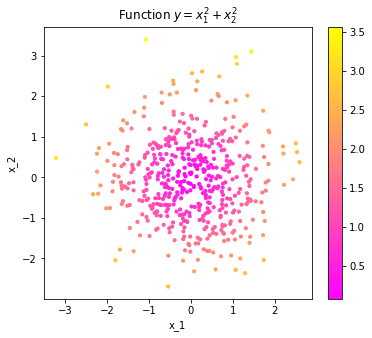

In [16]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

np.random.seed(13)
data_x = np.random.normal(size=(500, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 

plt.figure(figsize=(6, 5))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=10, cmap='spring')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('Function $y=x_1^2 + x_2^2$')
plt.show()

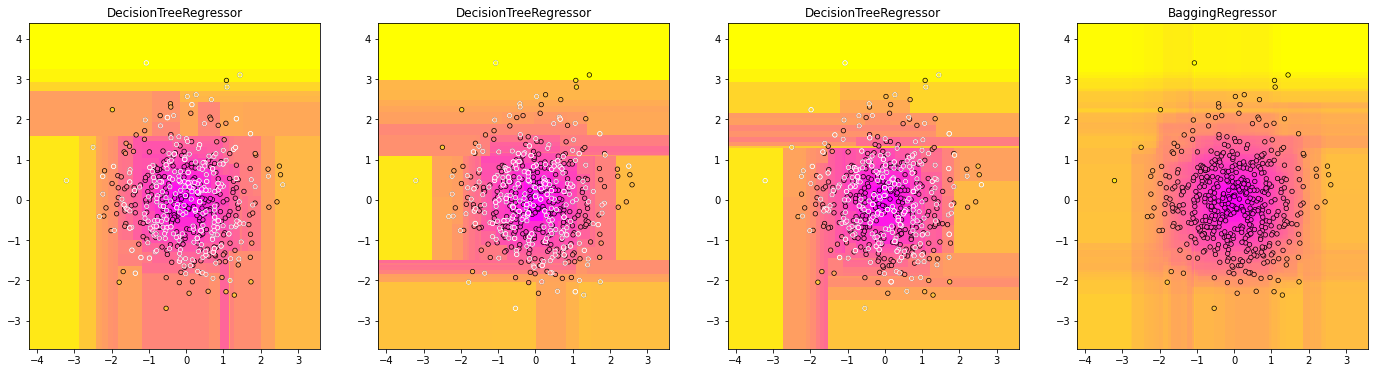

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

regressors = [DecisionTreeRegressor(random_state=13),
              DecisionTreeRegressor(random_state=13),
              DecisionTreeRegressor(random_state=13),
              BaggingRegressor()
           ]


fig, ax = plt.subplots(1, len(regressors))
fig.set_figheight(6)
fig.set_figwidth(len(regressors) * 6)

for i, clf in enumerate(regressors):
    rnd_i = np.random.randint(0, 500, 300)
    if i != len(regressors) - 1:
        clf.fit(data_x[rnd_i], data_y[rnd_i])
    else:
        clf.fit(data_x, data_y)
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax[i].set_title(clf.__class__.__name__)
    ax[i].pcolormesh(xx, yy, predicted, cmap='spring', shading='auto')
    ax[i].scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=20, cmap='spring', edgecolor='k', linewidth=0.7)
    if i != len(regressors) - 1:
        ax[i].scatter(data_x[rnd_i, 0], data_x[rnd_i, 1], c=data_y[rnd_i], s=20, cmap='spring', edgecolor='w', linewidth=0.8)
plt.show()

### Загрузим датасет Титаник

In [37]:
from sklearn.preprocessing import LabelEncoder
titanic = pd.read_csv('titanic.csv')[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
titanic.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [38]:
sex_encoder = LabelEncoder()
titanic.Sex = sex_encoder.fit_transform(titanic.Sex)
features = ['Pclass', 'Sex', 'Age', 'Fare']
X, y = titanic[features].values, titanic.Survived.values
X = np.nan_to_num(X)

In [39]:
titanic.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


### Обучим линейную модель на разных подвыборках, похожи ли коэфиценты?

In [48]:
from sklearn.linear_model import LogisticRegression

for n_items in [50, 200, 500, -1]:
    reg = LogisticRegression(solver='lbfgs').fit(X[:n_items], y[:n_items])
    print(f'n_items = {n_items:3.0f}, w = [{", ".join(map(lambda x: "%.4f" % x, reg.coef_[0]))}]')

n_items =  50, w = [-1.1774, -2.0075, -0.0330, -0.0157]
n_items = 200, w = [-0.9097, -2.5839, -0.0323, -0.0069]
n_items = 500, w = [-0.8532, -2.5949, -0.0168, -0.0010]
n_items =  -1, w = [-1.0253, -2.5290, -0.0152, 0.0013]


### Обучем деревья на тех же подвыборках, похожи ли деревья?

In [66]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree1 = DecisionTreeClassifier().fit(X[:200], y[:200])
tree2 = DecisionTreeClassifier().fit(X[:500], y[:500])

Если не работает pydot, то можно установить pydotplus и заменить все включения. Дополнительно необходимо установить graphviz для отображения дерева.
Подробности установки можно найти на http://graphviz.org/download/

In [67]:
# !pip3 install graphviz

In [68]:
# !pip3 install pydot

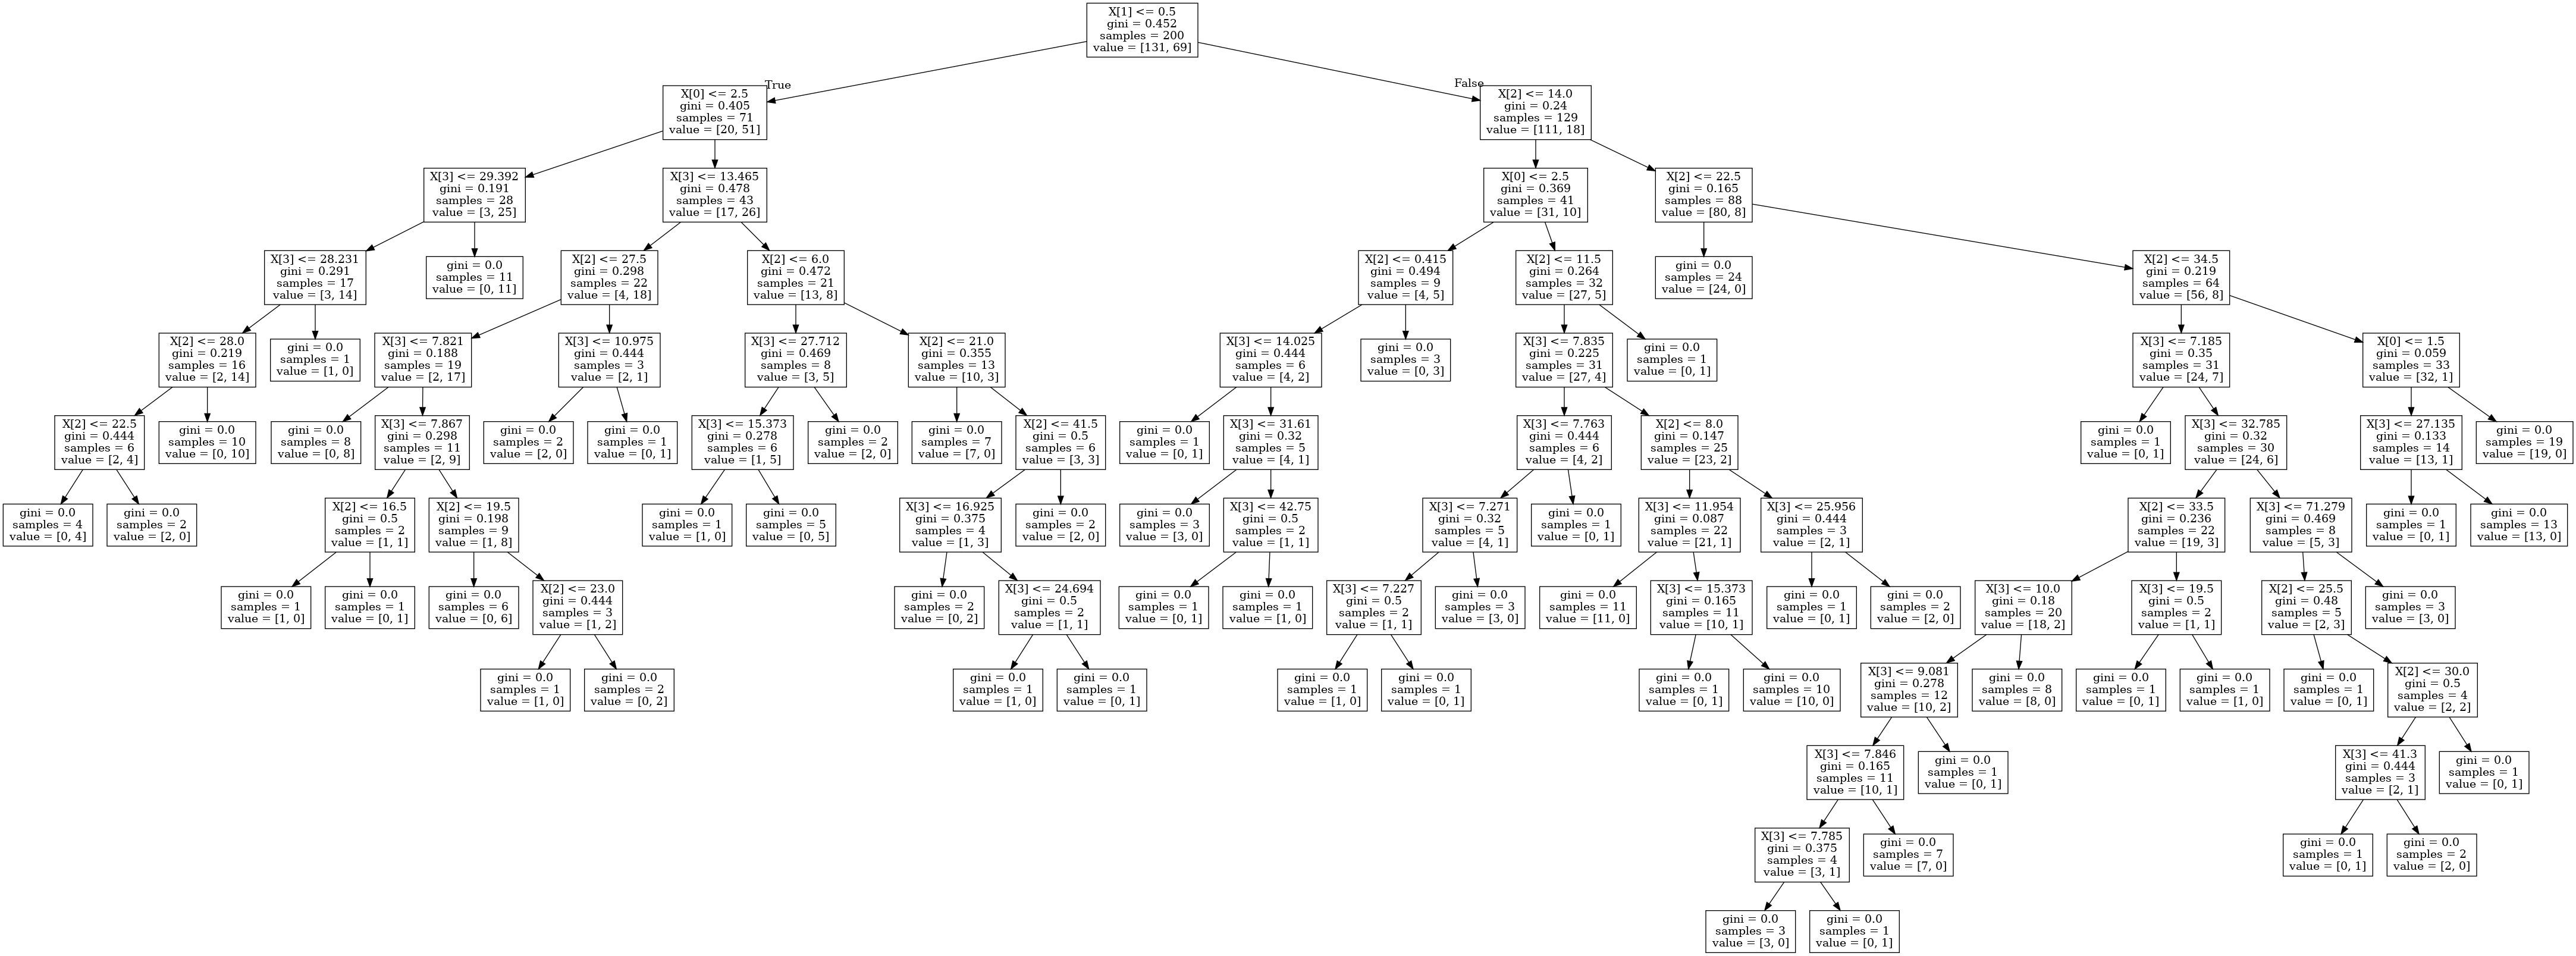

In [83]:
import pydot 
from IPython.display import Image  

tree1_graph = export_graphviz(tree1)
graph = pydot.graph_from_dot_data(tree1_graph)[0]
Image(graph.create_png())

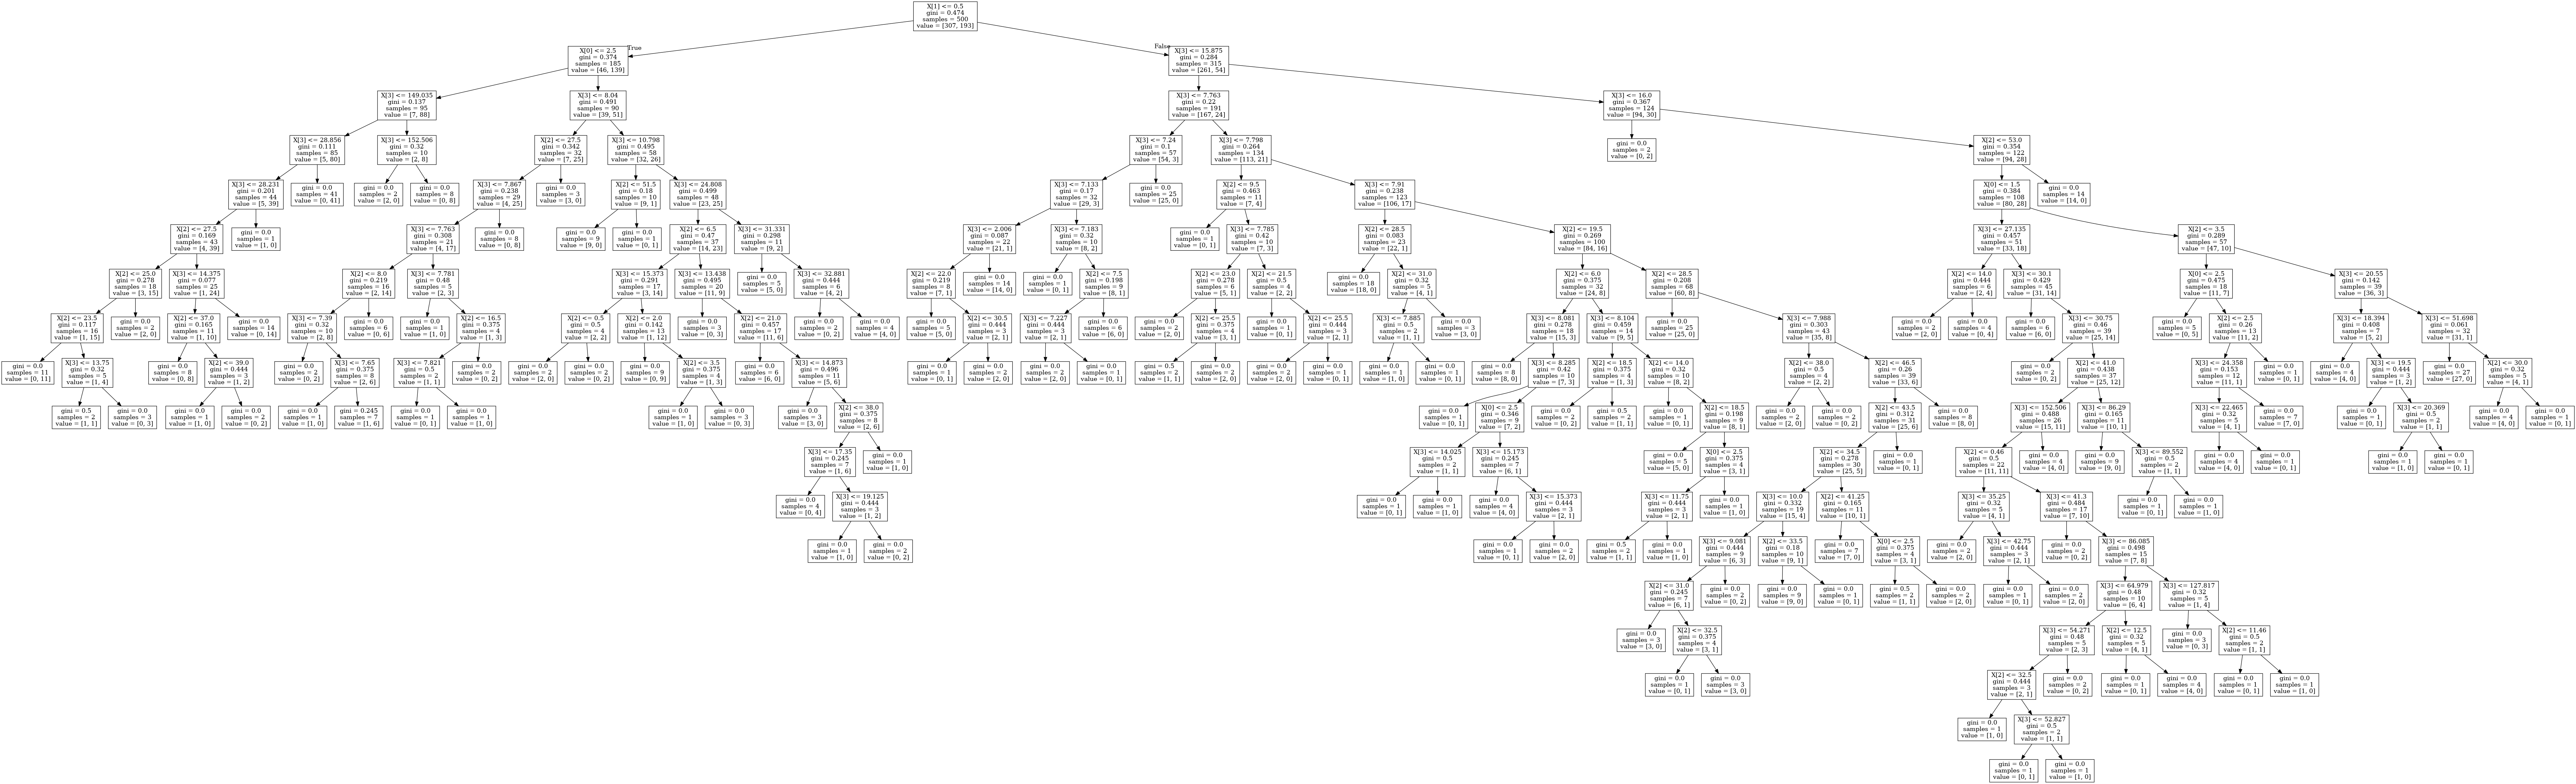

In [84]:
tree2_graph = export_graphviz(tree2) 
graph = pydot.graph_from_dot_data(tree2_graph)[0]
Image(graph.create_png()) 

## ?
В терминах **смещения** и **разброса**, у какой из двух моделей - линейной и дерева - больший разброс, а у какой большее смещение?

Тогда какая модель лучше будет для бэггинга, исходя из рассуждений в начале семинара?

---

## Бэггинг: практика
Рассмотрим другой датасет.

In [93]:
adult = pd.read_csv(
    'adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")

In [94]:
print(adult.shape)
adult.head()

(32561, 15)


,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [95]:
adult = pd.get_dummies(adult)
print(adult.shape)
adult.head()

(32561, 110)


,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [96]:
adult["Target"] = adult["Target_ >50K"]
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values

In [97]:
# нулевых классов примерно в 3 раза больше, чем 1
len(y[y==0]) / len(y[y==1])

3.152659099604642

### Беггинг на лог-регрессиях

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

In [101]:
# какой roc_auc дает одна логрегрессия?
lr = LogisticRegression()
scores1 = cross_val_score(lr, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores1.mean())

0.5799323675359154


In [103]:
# а что получится при ансамблировании?
clf2 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100)
scores2 = cross_val_score(clf2, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores2.mean())

0.5868828794012468


### Беггинг на деревьях

In [104]:
from sklearn.tree import DecisionTreeClassifier

In [105]:
# какой roc_auc дает одно решающее дерево?
dt = DecisionTreeClassifier()
scores1 = cross_val_score(dt, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores1.mean())

0.7505847616124224


In [106]:
# а что получится при ансамблировании?
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
scores2 = cross_val_score(clf2, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores2.mean())

0.9032522505082767


# Random Forest

Идея алгоритма примерно такая же, но каждое дерево обучается на случайном подмножестве признаков. То есть __рандомизация идет в двух направлениях__ - по числу примеров и по числу признаков. Отсюда __корреляция базовых алгоритмов падает__.

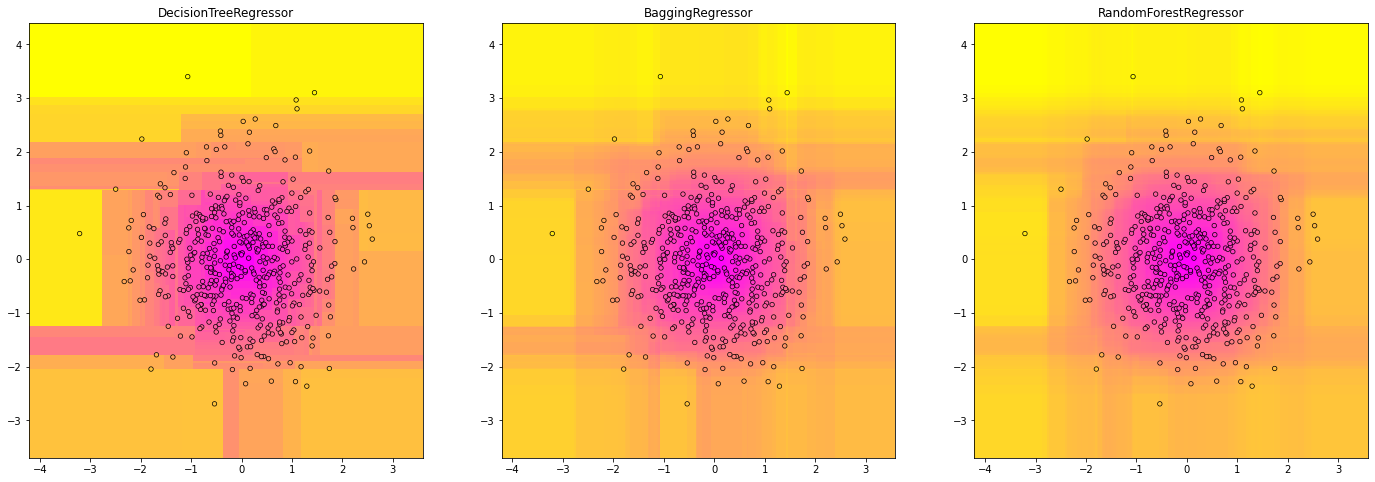

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

regressors = [DecisionTreeRegressor(random_state=13),
              BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=13)),
              RandomForestRegressor(),]

fig, ax = plt.subplots(1, 3)
fig.set_figheight(8)
fig.set_figwidth(24)

for i, clf in enumerate(regressors):
    clf.fit(data_x, data_y)

    xx, yy = get_grid(data_x)

    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax[i].set_title(clf.__class__.__name__)
    ax[i].pcolormesh(xx, yy, predicted, cmap='spring', shading='auto')
    ax[i].scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=20, cmap='spring', edgecolor='k', linewidth=0.7)
plt.show()

На самом деле на этом примере не очень корректно это отображать, поскольку фич всего-то две.

In [111]:
from sklearn.ensemble import RandomForestClassifier

dt = RandomForestClassifier(n_estimators=100)
scores1 = cross_val_score(dt, X, y, cv=4, n_jobs=4, scoring='accuracy', )
print(scores1.mean())

0.8545499740899568
